# Pixel Play '26: Complete Pipeline

## Steps:
1. **Flip Detection & Correction** - Train CNN to detect and fix flipped frames
2. **Denoising Autoencoder** - Train autoencoder with Input=Noisy, Target=Clean
3. **Anomaly Detection** - Use reconstruction error as anomaly score
4. **Submission** - Normalize, smooth, and create CSV

---
## Cell 1: Imports & Setup

In [6]:
import numpy as np
import os
import shutil
from tqdm import tqdm
import random
import re
import zipfile

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import pandas as pd
from scipy.ndimage import uniform_filter1d

# Seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


---
## Cell 2: Configuration (EDIT THIS!)

In [7]:
# ====================
# PATHS
# ====================
TRAIN_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
TEST_PATH_ORIGINAL = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Intermediate: After flip correction
FLIP_CLEANED_PATH = '/kaggle/working/flip_cleaned_testing_videos'

# ====================
# MODE SELECTION
# ====================
COLOR_MODE = 'grayscale'  # Options: 'grayscale' or 'rgb'

# ====================
# FLIP DETECTOR CONFIG
# ====================
FLIP_EPOCHS = 5
FLIP_BATCH_SIZE = 64
FLIP_LR = 0.001
FLIP_IMG_SIZE = 64
FLIP_SAMPLES = 3000

# ====================
# NOISE CONFIG (Matching your test data)
# ====================
# Grayscale noise
NOISE_STRENGTH_GRAY = 40  # In 0-255 scale

# RGB noise (per channel)
NOISE_STRENGTH_R = 35
NOISE_STRENGTH_G = 35
NOISE_STRENGTH_B = 35

NOISE_MODE = "symmetric"  # "symmetric" => U(-A,+A), "positive" => U(0,+A)

# ====================
# DENOISING AUTOENCODER CONFIG
# ====================
IMG_SIZE = 128
TEMPORAL_LENGTH = 16
STRIDE = 2
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001

# ====================
# TEMPORAL SMOOTHING
# ====================
SMOOTHING_WINDOW = 15

# ====================
# OUTPUT CONFIG
# ====================
MODEL_SAVE_NAME = 'denoising_autoencoder.pth'
FLIP_MODEL_NAME = 'flip_detector.pth'
SUBMISSION_FILE = 'submission.csv'
OUTPUT_ZIP = 'pixelplay_output.zip'

# ====================
# PRINT CONFIG
# ====================
print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Color Mode: {COLOR_MODE}")
print(f"\nNoise Settings:")
if COLOR_MODE == 'grayscale':
    print(f"  Grayscale Strength: {NOISE_STRENGTH_GRAY}")
else:
    print(f"  R Channel: {NOISE_STRENGTH_R}")
    print(f"  G Channel: {NOISE_STRENGTH_G}")
    print(f"  B Channel: {NOISE_STRENGTH_B}")
print(f"  Mode: {NOISE_MODE}")
print(f"\nModel Settings:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Temporal Length: {TEMPORAL_LENGTH}")
print(f"  Stride: {STRIDE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Smoothing Window: {SMOOTHING_WINDOW}")
print("="*60)

CONFIGURATION
Color Mode: grayscale

Noise Settings:
  Grayscale Strength: 40
  Mode: symmetric

Model Settings:
  Image Size: 128
  Temporal Length: 16
  Stride: 2
  Epochs: 25
  Smoothing Window: 15


---
## Cell 3: Noise Functions

In [8]:
def add_uniform_grayscale_noise(x, strength=35, mode="symmetric"):
    """
    Add uniform noise to grayscale tensor.
    
    Args:
        x: tensor in range [0,1] -> shape (B, T, H, W) or (T, H, W)
        strength: max noise value in 0-255 scale
        mode: "symmetric" => U(-A,+A), "positive" => U(0,+A)
    
    Returns:
        Noisy tensor clamped to [0,1]
    """
    A = strength / 255.0
    if mode == "symmetric":
        noise = torch.empty_like(x).uniform_(-A, A)
    else:
        noise = torch.empty_like(x).uniform_(0, A)
    noisy = x + noise
    noisy = torch.clamp(noisy, 0.0, 1.0)
    return noisy


def add_uniform_rgb_noise(x, strength_r=35, strength_g=35, strength_b=35, mode="symmetric"):
    """
    Add uniform noise to RGB tensor (per channel).
    
    Args:
        x: tensor in range [0,1] -> shape (B, T*3, H, W) or (T*3, H, W)
        strength_r/g/b: max noise value in 0-255 scale per channel
        mode: "symmetric" => U(-A,+A), "positive" => U(0,+A)
    
    Returns:
        Noisy tensor clamped to [0,1]
    """
    A_r = strength_r / 255.0
    A_g = strength_g / 255.0
    A_b = strength_b / 255.0
    
    noisy = x.clone()
    
    # Handle batched (B, T*3, H, W)
    if len(x.shape) == 4:
        channels = x.shape[1]
        t = channels // 3
        for i in range(t):
            idx_r, idx_g, idx_b = i*3, i*3+1, i*3+2
            if mode == "symmetric":
                noisy[:, idx_r] += torch.empty_like(x[:, idx_r]).uniform_(-A_r, A_r)
                noisy[:, idx_g] += torch.empty_like(x[:, idx_g]).uniform_(-A_g, A_g)
                noisy[:, idx_b] += torch.empty_like(x[:, idx_b]).uniform_(-A_b, A_b)
            else:
                noisy[:, idx_r] += torch.empty_like(x[:, idx_r]).uniform_(0, A_r)
                noisy[:, idx_g] += torch.empty_like(x[:, idx_g]).uniform_(0, A_g)
                noisy[:, idx_b] += torch.empty_like(x[:, idx_b]).uniform_(0, A_b)
    # Handle single sample (T*3, H, W)
    else:
        channels = x.shape[0]
        t = channels // 3
        for i in range(t):
            idx_r, idx_g, idx_b = i*3, i*3+1, i*3+2
            if mode == "symmetric":
                noisy[idx_r] += torch.empty_like(x[idx_r]).uniform_(-A_r, A_r)
                noisy[idx_g] += torch.empty_like(x[idx_g]).uniform_(-A_g, A_g)
                noisy[idx_b] += torch.empty_like(x[idx_b]).uniform_(-A_b, A_b)
            else:
                noisy[idx_r] += torch.empty_like(x[idx_r]).uniform_(0, A_r)
                noisy[idx_g] += torch.empty_like(x[idx_g]).uniform_(0, A_g)
                noisy[idx_b] += torch.empty_like(x[idx_b]).uniform_(0, A_b)
    
    noisy = torch.clamp(noisy, 0.0, 1.0)
    return noisy


def add_noise(x, color_mode='grayscale'):
    """Wrapper function to add noise based on color mode."""
    if color_mode == 'grayscale':
        return add_uniform_grayscale_noise(x, NOISE_STRENGTH_GRAY, NOISE_MODE)
    else:
        return add_uniform_rgb_noise(x, NOISE_STRENGTH_R, NOISE_STRENGTH_G, NOISE_STRENGTH_B, NOISE_MODE)

print("Noise functions defined!")

Noise functions defined!


---
## Cell 4: Flip Detector Dataset & Model

In [9]:
class FlipDetectionDataset(Dataset):
    """Dataset: Normal (0) vs Flipped (1)"""
    
    def __init__(self, video_path, samples_per_class=3000):
        self.transform = transforms.Compose([
            transforms.Resize((FLIP_IMG_SIZE, FLIP_IMG_SIZE)),
            transforms.ToTensor(),
        ])
        
        self.frame_paths = []
        for folder in os.listdir(video_path):
            folder_path = os.path.join(video_path, folder)
            if os.path.isdir(folder_path):
                for frame in os.listdir(folder_path):
                    if frame.endswith(('.jpg', '.png')):
                        self.frame_paths.append(os.path.join(folder_path, frame))
        
        print(f"Total frames: {len(self.frame_paths)}")
        
        selected = random.sample(self.frame_paths, min(samples_per_class, len(self.frame_paths)))
        
        self.samples = []
        for path in selected:
            self.samples.append((path, 0))  # Normal
            self.samples.append((path, 1))  # Flipped
        random.shuffle(self.samples)
        print(f"Training samples: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('L')
        img_tensor = self.transform(img)
        if label == 1:
            img_tensor = TF.vflip(img_tensor)
        return img_tensor, torch.tensor(label, dtype=torch.long)


class FlipDetectorCNN(nn.Module):
    """Small CNN for flip detection"""
    
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 2),
        )
    
    def forward(self, x):
        return self.classifier(self.features(x))

print("Flip detector classes defined!")

Flip detector classes defined!


---
## Cell 5: Train Flip Detector

In [10]:
print("\n" + "="*60)
print("STEP 1: TRAINING FLIP DETECTOR")
print("="*60)

flip_dataset = FlipDetectionDataset(TRAIN_PATH, FLIP_SAMPLES)
flip_loader = DataLoader(flip_dataset, batch_size=FLIP_BATCH_SIZE, shuffle=True, num_workers=2)

flip_model = FlipDetectorCNN().to(device)
flip_criterion = nn.CrossEntropyLoss()
flip_optimizer = optim.Adam(flip_model.parameters(), lr=FLIP_LR)

print(f"Parameters: {sum(p.numel() for p in flip_model.parameters()):,}")

flip_model.train()
for epoch in range(FLIP_EPOCHS):
    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(flip_loader, desc=f'Flip Epoch {epoch+1}/{FLIP_EPOCHS}')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = flip_model(images)
        loss = flip_criterion(outputs, labels)
        flip_optimizer.zero_grad()
        loss.backward()
        flip_optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})
    print(f'Epoch {epoch+1}: Loss={total_loss/len(flip_loader):.4f}, Acc={100*correct/total:.1f}%')

torch.save(flip_model.state_dict(), FLIP_MODEL_NAME)
print(f"Saved: {FLIP_MODEL_NAME}")


STEP 1: TRAINING FLIP DETECTOR
Total frames: 9204
Training samples: 6000
Parameters: 25,442


Flip Epoch 1/5: 100%|██████████| 94/94 [00:24<00:00,  3.87it/s, loss=0.5508, acc=63.6%]


Epoch 1: Loss=0.6721, Acc=63.6%


Flip Epoch 2/5: 100%|██████████| 94/94 [00:13<00:00,  6.94it/s, loss=0.0077, acc=99.3%]


Epoch 2: Loss=0.1302, Acc=99.3%


Flip Epoch 3/5: 100%|██████████| 94/94 [00:13<00:00,  6.90it/s, loss=0.0020, acc=100.0%]


Epoch 3: Loss=0.0052, Acc=100.0%


Flip Epoch 4/5: 100%|██████████| 94/94 [00:13<00:00,  7.15it/s, loss=0.0002, acc=100.0%]


Epoch 4: Loss=0.0019, Acc=100.0%


Flip Epoch 5/5: 100%|██████████| 94/94 [00:12<00:00,  7.31it/s, loss=0.0009, acc=100.0%]

Epoch 5: Loss=0.0018, Acc=100.0%
Saved: flip_detector.pth


---
## Cell 6: Correct Flipped Test Frames

In [11]:
print("\n" + "="*60)
print("STEP 2: CORRECTING FLIPPED FRAMES")
print("="*60)

flip_model.eval()
flip_transform = transforms.Compose([
    transforms.Resize((FLIP_IMG_SIZE, FLIP_IMG_SIZE)),
    transforms.ToTensor(),
])

if os.path.exists(FLIP_CLEANED_PATH):
    shutil.rmtree(FLIP_CLEANED_PATH)
os.makedirs(FLIP_CLEANED_PATH)

flipped_count = 0
total_count = 0

video_folders = sorted([f for f in os.listdir(TEST_PATH_ORIGINAL) 
                        if os.path.isdir(os.path.join(TEST_PATH_ORIGINAL, f))])

with torch.no_grad():
    for folder in tqdm(video_folders, desc='Correcting flips'):
        src_folder = os.path.join(TEST_PATH_ORIGINAL, folder)
        dst_folder = os.path.join(FLIP_CLEANED_PATH, folder)
        os.makedirs(dst_folder, exist_ok=True)
        
        frames = sorted([f for f in os.listdir(src_folder) if f.endswith(('.jpg', '.png'))])
        
        for frame_name in frames:
            src_path = os.path.join(src_folder, frame_name)
            dst_path = os.path.join(dst_folder, frame_name)
            
            img_gray = Image.open(src_path).convert('L')
            img_tensor = flip_transform(img_gray).unsqueeze(0).to(device)
            output = flip_model(img_tensor)
            is_flipped = torch.softmax(output, dim=1)[0, 1].item() > 0.5
            
            img_original = Image.open(src_path)
            
            if is_flipped:
                img_corrected = TF.vflip(transforms.ToTensor()(img_original))
                transforms.ToPILImage()(img_corrected).save(dst_path)
                flipped_count += 1
            else:
                shutil.copy2(src_path, dst_path)
            
            total_count += 1

print(f"\nFlipped corrected: {flipped_count} ({100*flipped_count/total_count:.1f}%)")
print(f"Total frames: {total_count}")


STEP 2: CORRECTING FLIPPED FRAMES


Correcting flips: 100%|██████████| 21/21 [02:57<00:00,  8.47s/it]


Flipped corrected: 1195 (10.2%)
Total frames: 11706


---
## Cell 7: Denoising Autoencoder Dataset

In [12]:
class DenoisingVideoDataset(Dataset):
    """
    Denoising Dataset: Input=Noisy, Target=Clean
    Supports grayscale and RGB modes.
    """
    
    def __init__(self, video_path, temporal_length=10, stride=1, img_size=128,
                 color_mode='grayscale', is_train=True):
        self.video_path = video_path
        self.temporal_length = temporal_length
        self.stride = stride
        self.img_size = img_size
        self.color_mode = color_mode
        self.is_train = is_train
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])
        
        self.samples = []
        self._prepare_samples()
    
    def _prepare_samples(self):
        video_folders = sorted([f for f in os.listdir(self.video_path)
                               if os.path.isdir(os.path.join(self.video_path, f))])
        
        for folder in video_folders:
            folder_path = os.path.join(self.video_path, folder)
            frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
            max_start = len(frames) - self.temporal_length
            for start_idx in range(0, max_start + 1, self.stride):
                self.samples.append((folder, start_idx))
        
        print(f"Dataset: {len(self.samples)} samples (T={self.temporal_length}, stride={self.stride}, mode={self.color_mode})")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        folder, start_idx = self.samples[idx]
        folder_path = os.path.join(self.video_path, folder)
        frames = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
        
        clean_frames = []
        for i in range(self.temporal_length):
            frame_path = os.path.join(folder_path, frames[start_idx + i])
            if self.color_mode == 'grayscale':
                img = Image.open(frame_path).convert('L')
            else:
                img = Image.open(frame_path).convert('RGB')
            clean_frames.append(self.transform(img))
        
        clean_cuboid = torch.cat(clean_frames, dim=0)
        
        if self.is_train:
            noisy_cuboid = add_noise(clean_cuboid.unsqueeze(0), self.color_mode).squeeze(0)
            return noisy_cuboid, clean_cuboid
        else:
            return clean_cuboid, clean_cuboid

print("Denoising dataset class defined!")

Denoising dataset class defined!


---
## Cell 8: Denoising Autoencoder Model

In [13]:
class DenoisingConvAutoencoder(nn.Module):
    """
    Denoising Autoencoder
    Grayscale: channels = T
    RGB: channels = T * 3
    """
    
    def __init__(self, temporal_length=10, color_mode='grayscale'):
        super().__init__()
        
        in_ch = temporal_length if color_mode == 'grayscale' else temporal_length * 3
        self.in_channels = in_ch
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 512, 3, 2, 1), nn.ReLU(True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, in_ch, 3, 2, 1, 1), nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

print("Denoising autoencoder model defined!")

Denoising autoencoder model defined!


---
## Cell 9: Train Denoising Autoencoder

In [14]:
print("\n" + "="*60)
print("STEP 3: TRAINING DENOISING AUTOENCODER")
print("="*60)
print(f"Mode: {COLOR_MODE} | Noise: {NOISE_STRENGTH_GRAY if COLOR_MODE == 'grayscale' else 'RGB'}")

train_dataset = DenoisingVideoDataset(
    TRAIN_PATH, TEMPORAL_LENGTH, STRIDE, IMG_SIZE, COLOR_MODE, is_train=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = DenoisingConvAutoencoder(TEMPORAL_LENGTH, COLOR_MODE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

model.train()
train_losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    pbar = tqdm(train_loader, desc=f'Denoise Epoch {epoch+1}/{EPOCHS}')
    
    for noisy_input, clean_target in pbar:
        noisy_input, clean_target = noisy_input.to(device), clean_target.to(device)
        output = model(noisy_input)
        loss = criterion(output, clean_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}: Loss={epoch_loss:.6f}')

torch.save(model.state_dict(), MODEL_SAVE_NAME)
print(f"Saved: {MODEL_SAVE_NAME}")


STEP 3: TRAINING DENOISING AUTOENCODER
Mode: grayscale | Noise: 40
Dataset: 4486 samples (T=16, stride=2, mode=grayscale)
Parameters: 3,116,432


Denoise Epoch 1/25: 100%|██████████| 141/141 [03:22<00:00,  1.43s/it, loss=0.004401]


Epoch 1: Loss=0.016458


Denoise Epoch 2/25: 100%|██████████| 141/141 [02:47<00:00,  1.19s/it, loss=0.002445]


Epoch 2: Loss=0.002995


Denoise Epoch 3/25: 100%|██████████| 141/141 [02:51<00:00,  1.22s/it, loss=0.001830]


Epoch 3: Loss=0.001948


Denoise Epoch 4/25: 100%|██████████| 141/141 [02:52<00:00,  1.22s/it, loss=0.001567]


Epoch 4: Loss=0.001562


Denoise Epoch 5/25: 100%|██████████| 141/141 [02:52<00:00,  1.22s/it, loss=0.001169]


Epoch 5: Loss=0.001388


Denoise Epoch 6/25: 100%|██████████| 141/141 [02:55<00:00,  1.24s/it, loss=0.000921]


Epoch 6: Loss=0.001202


Denoise Epoch 7/25: 100%|██████████| 141/141 [02:54<00:00,  1.24s/it, loss=0.001036]


Epoch 7: Loss=0.001141


Denoise Epoch 8/25: 100%|██████████| 141/141 [02:59<00:00,  1.27s/it, loss=0.001043]


Epoch 8: Loss=0.001066


Denoise Epoch 9/25: 100%|██████████| 141/141 [02:56<00:00,  1.25s/it, loss=0.000935]


Epoch 9: Loss=0.001009


Denoise Epoch 10/25: 100%|██████████| 141/141 [02:59<00:00,  1.27s/it, loss=0.000817]


Epoch 10: Loss=0.000979


Denoise Epoch 11/25: 100%|██████████| 141/141 [02:58<00:00,  1.27s/it, loss=0.001273]


Epoch 11: Loss=0.000935


Denoise Epoch 12/25: 100%|██████████| 141/141 [02:54<00:00,  1.24s/it, loss=0.000803]


Epoch 12: Loss=0.000908


Denoise Epoch 13/25: 100%|██████████| 141/141 [02:58<00:00,  1.27s/it, loss=0.000703]


Epoch 13: Loss=0.000875


Denoise Epoch 14/25: 100%|██████████| 141/141 [02:55<00:00,  1.24s/it, loss=0.000797]


Epoch 14: Loss=0.000845


Denoise Epoch 15/25: 100%|██████████| 141/141 [03:04<00:00,  1.31s/it, loss=0.000942]


Epoch 15: Loss=0.000847


Denoise Epoch 16/25:  10%|▉         | 14/141 [00:18<02:45,  1.30s/it, loss=0.000861]


KeyboardInterrupt: 

---
## Cell 10: Plot Training Curve

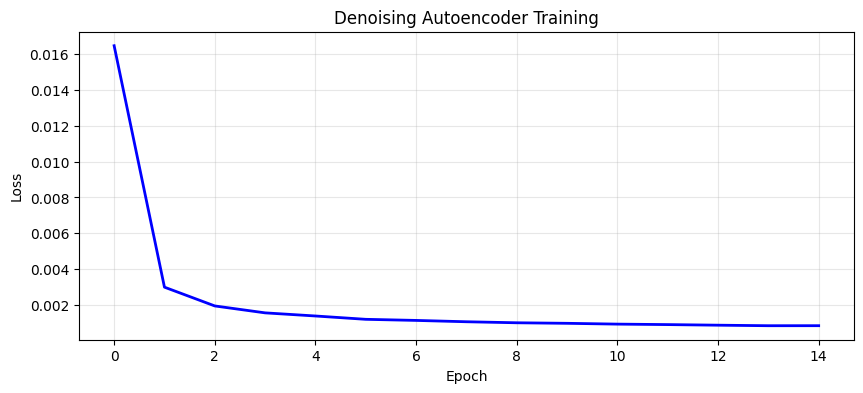

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Denoising Autoencoder Training')
plt.grid(True, alpha=0.3)
plt.savefig('training_curve.png', dpi=150)
plt.show()

---
## Cell 11: Prediction Functions

In [17]:
def extract_frame_number(filename):
    match = re.search(r'(\d+)', os.path.splitext(filename)[0])
    return int(match.group(1)) if match else 0


def predict_video(model, video_path, temporal_length, img_size, color_mode, device):
    model.eval()
    transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
    
    frames = sorted([f for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    frame_errors = {i: [] for i in range(len(frames))}
    
    with torch.no_grad():
        for start_idx in range(len(frames) - temporal_length + 1):
            cuboid_frames = []
            for i in range(temporal_length):
                frame_path = os.path.join(video_path, frames[start_idx + i])
                if color_mode == 'grayscale':
                    img = Image.open(frame_path).convert('L')
                else:
                    img = Image.open(frame_path).convert('RGB')
                cuboid_frames.append(transform(img))
            
            cuboid = torch.cat(cuboid_frames, dim=0).unsqueeze(0).to(device)
            output = model(cuboid)
            
            if color_mode == 'grayscale':
                error = (cuboid - output).pow(2).mean(dim=[2, 3]).squeeze().cpu().numpy()
            else:
                error = (cuboid - output).pow(2).view(-1, temporal_length, 3, img_size, img_size)
                error = error.mean(dim=[2, 3, 4]).squeeze().cpu().numpy()
            
            if temporal_length == 1:
                frame_errors[start_idx].append(float(error))
            else:
                error = np.atleast_1d(error)
                for i in range(temporal_length):
                    frame_errors[start_idx + i].append(error[i])
    
    avg_errors = {idx: np.mean(errs) if errs else 0.0 for idx, errs in frame_errors.items()}
    
    frame_scores = {}
    for idx, frame_name in enumerate(frames):
        frame_scores[extract_frame_number(frame_name)] = avg_errors.get(idx, 0.0)
    
    return frame_scores


def normalize_predictions_global(raw_preds):
    """Global normalization across ALL videos."""
    # Collect ALL scores
    all_scores = []
    for vid, scores in raw_preds.items():
        all_scores.extend(scores.values())
    
    all_scores = np.array(all_scores)
    p5, p95 = np.percentile(all_scores, [1, 100])  # ← Global percentiles
    
    normalized = {}
    for vid, scores in raw_preds.items():
        if p95 > p5:
            normalized[vid] = {f: np.clip((s - p5) / (p95 - p5), 0, 1) for f, s in scores.items()}
        else:
            normalized[vid] = {f: 0.5 for f in scores}
    
    return normalized


def smooth_predictions(norm_preds, window=5):
    smoothed = {}
    for vid, errors in norm_preds.items():
        indices = sorted(errors.keys())
        values = np.array([errors[i] for i in indices])
        smooth_values = uniform_filter1d(values, size=window)
        smoothed[vid] = {i: smooth_values[j] for j, i in enumerate(indices)}
    return smoothed


def create_submission(predictions, test_path):
    data = []
    for vid in sorted(predictions.keys()):
        for frame in sorted(predictions[vid].keys()):
            data.append({'Id': f"{vid}_{frame}", 'Predicted': predictions[vid][frame]})
    return pd.DataFrame(data)

print("Prediction functions defined!")

Prediction functions defined!


---
## Cell 12: Run Predictions

In [18]:
print("\n" + "="*60)
print("STEP 4: RUNNING PREDICTIONS")
print("="*60)

raw_predictions = {}

video_folders = sorted([f for f in os.listdir(FLIP_CLEANED_PATH) 
                        if os.path.isdir(os.path.join(FLIP_CLEANED_PATH, f))])

for folder in tqdm(video_folders, desc='Predicting'):
    video_id = int(folder)
    video_path = os.path.join(FLIP_CLEANED_PATH, folder)
    raw_predictions[video_id] = predict_video(model, video_path, TEMPORAL_LENGTH, IMG_SIZE, COLOR_MODE, device)

print(f"Predictions done for {len(raw_predictions)} videos")


STEP 4: RUNNING PREDICTIONS


Predicting: 100%|██████████| 21/21 [09:37<00:00, 27.52s/it]

Predictions done for 21 videos


---
## Cell 13: Normalize, Smooth & Save Submissions

In [20]:
print("\n" + "="*60)
print("STEP 5: CREATING SUBMISSIONS")
print("="*60)

# Normalize
normalized_predictions = normalize_predictions_global(raw_predictions)

# Smooth
smoothed_predictions = smooth_predictions(normalized_predictions, SMOOTHING_WINDOW)

# Save both
submission_raw = create_submission(normalized_predictions, FLIP_CLEANED_PATH)
submission_raw.to_csv('submission_raw.csv', index=False)

submission_smooth = create_submission(smoothed_predictions, FLIP_CLEANED_PATH)
submission_smooth.to_csv(SUBMISSION_FILE, index=False)

print(f"Saved: submission_raw.csv")
print(f"Saved: {SUBMISSION_FILE} (smoothed)")
print(f"\nTotal predictions: {len(submission_smooth)}")
print("\nSample predictions:")
print(submission_smooth.head(10))


STEP 5: CREATING SUBMISSIONS
Saved: submission_raw.csv
Saved: submission.csv (smoothed)

Total predictions: 11706

Sample predictions:
      Id  Predicted
0  1_939   0.736914
1  1_940   0.732922
2  1_941   0.726875
3  1_942   0.720741
4  1_943   0.712068
5  1_944   0.705770
6  1_945   0.707159
7  1_946   0.713317
8  1_947   0.719394
9  1_948   0.719754
